In [ ]:
#!pip install pyabel


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import abel
from PIL import Image


In [2]:
CartImage = Image.open("D:\\gitcustomers\\Pill-CBIR-Keras-CNN\\data\\test\\images\\229.jpg").convert('L')

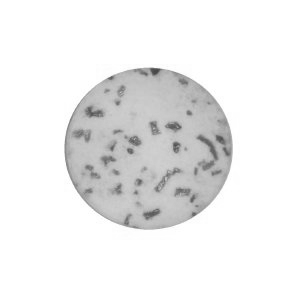

In [3]:
CartImage

In [4]:
CartImageData = np.asarray(CartImage.convert('L'), dtype="int32" ) 

In [5]:
CartImageData

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [6]:
PolarImageData, r_grid, theta_grid = abel.tools.polar.reproject_image_into_polar(CartImageData, Jacobian=True)

In [13]:
PolarImageData


array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [202.32682032, 202.32682032, 202.32682032, ..., 202.32682032,
        202.32682032, 202.32682032],
       [406.64700833, 406.64700833, 406.64700833, ..., 406.64700833,
        406.64700833, 406.64700833],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [19]:
PolarImage = PolarImage.convert('L')

In [22]:
PolarImage = Image.fromarray(PolarImageData)

In [25]:
PolarImagePIL

NameError: name 'PolarImagePIL' is not defined

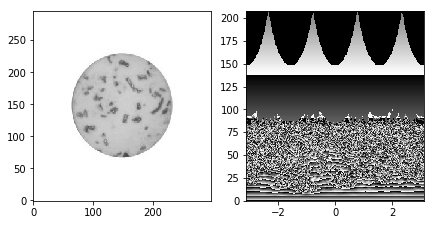

In [17]:
fig, axs = plt.subplots(1,2, figsize=(7,3.5))
axs[0].imshow(CartImage, aspect='auto', origin='lower')
#axs[1].imshow(PolarImage3, aspect='auto', origin='lower', 
#            extent=(np.min(theta_grid), np.max(theta_grid), np.min(r_grid), np.max(r_grid)))
axs[1].imshow(PolarImage, aspect='auto', origin='lower',
             extent=(np.min(theta_grid), np.max(theta_grid), np.min(r_grid), np.max(r_grid)))

In [ ]:
CartImage


In [ ]:
ci = CartImage
cid = np.asarray(ci.convert('L'), dtype="int32" ) 
pid, r_grid, theta_grid = abel.tools.polar.reproject_image_into_polar(cid, Jacobian=True)
pi = Image.fromarray(np.uint8(pid), 'L')
pi

In [27]:
import numpy as np
import scipy as sp
import scipy.ndimage
from PIL import Image
import matplotlib.pyplot as plt

In [28]:
def plot_polar_image(data, origin=None):
    """Plots an image reprojected into polar coordinages with the origin
    at "origin" (a tuple of (x0, y0), defaults to the center of the image)"""
    polar_grid, r, theta = reproject_image_into_polar(data, origin)
    plt.figure()
    plt.imshow(polar_grid, extent=(theta.min(), theta.max(), r.max(), r.min()))
    plt.axis('auto')
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel('Theta Coordinate (radians)')
    plt.ylabel('R Coordinate (pixels)')
    plt.title('Image in Polar Coordinates')

In [29]:
def index_coords(data, origin=None):
    """Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def cart2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

In [30]:
def reproject_image_into_polar(data, origin=None):
    """Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    r, theta = cart2polar(x, y)

    # Make a regular (in polar space) grid based on the min and max r & theta
    r_i = np.linspace(r.min(), r.max(), nx)
    theta_i = np.linspace(theta.min(), theta.max(), ny)
    theta_grid, r_grid = np.meshgrid(theta_i, r_i)

    # Project the r and theta grid back into pixel coordinates
    xi, yi = polar2cart(r_grid, theta_grid)
    xi += origin[0] # We need to shift the origin back to 
    yi += origin[1] # back to the lower-left corner...
    xi, yi = xi.flatten(), yi.flatten()
    coords = np.vstack((xi, yi)) # (map_coordinates requires a 2xn array)

    # Reproject each band individually and the restack
    # (uses less memory than reprojection the 3-dimensional array in one step)
    bands = []
    for band in data.T:
        zi = sp.ndimage.map_coordinates(band, coords, order=1)
        bands.append(zi.reshape((nx, ny)))
    output = np.dstack(bands)
    return output, r_i, theta_i


In [32]:
def plot_directional_intensity(data, origin=None):
    """Makes a cicular histogram showing average intensity binned by direction
    from "origin" for each band in "data" (a 3D numpy array). "origin" defaults
    to the center of the image."""
    def intensity_rose(theta, band, color):
        theta, band = theta.flatten(), band.flatten()
        intensities, theta_bins = bin_by(band, theta)
        mean_intensity = map(np.mean, intensities)
        width = np.diff(theta_bins)[0]
        plt.bar(theta_bins, mean_intensity, width=width, color=color)
        plt.xlabel(color + ' Band')
        plt.yticks([])

    # Make cartesian coordinates for the pixel indicies
    # (The origin defaults to the center of the image)
    x, y = index_coords(data, origin)

    # Convert the pixel indices into polar coords.
    r, theta = cart2polar(x, y)

    # Unpack bands of the image
    red, green, blue = data.T

    # Plot...
    plt.figure()

    plt.subplot(2,2,1, projection='polar')
    intensity_rose(theta, red, 'Red')

    plt.subplot(2,2,2, projection='polar')
    intensity_rose(theta, green, 'Green')

    plt.subplot(2,1,2, projection='polar')
    intensity_rose(theta, blue, 'Blue')

    plt.suptitle('Average intensity as a function of direction')

In [34]:
def bin_by(x, y, nbins=30):
    """Bin x by y, given paired observations of x & y.
    Returns the binned "x" values and the left edges of the bins."""
    bins = np.linspace(y.min(), y.max(), nbins+1)
    # To avoid extra bin for the max value
    bins[-1] += 1 

    indicies = np.digitize(y, bins)

    output = []
    for i in xrange(1, len(bins)):
        output.append(x[indicies==i])

    # Just return the left edges of the bins
    bins = bins[:-1]

    return output, bins

NameError: name 'xrange' is not defined

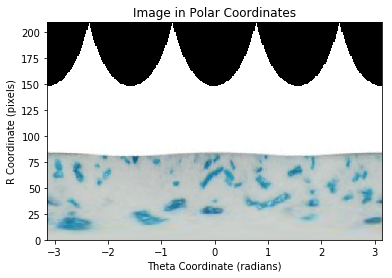

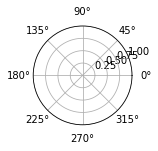

In [35]:
#im = Image.open('mri_demo.png')
im = Image.open("D:\\gitcustomers\\Pill-CBIR-Keras-CNN\\data\\test\\images\\229.jpg")
im = im.convert('RGB')
data = np.array(im)

plot_polar_image(data, origin=None)
plot_directional_intensity(data, origin=None)

plt.show()